In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import implicit
import scipy
import json
import math
import gzip
import tqdm
from datetime import datetime

In [2]:
movies_file = "./douban/moviereviews_cleaned.txt"
music_file = "./douban/musicreviews_cleaned.txt"

In [94]:
music = pd.read_csv(music_file, sep="\t", index_col="ID")
music.time = pd.to_datetime(music.time)
music.useful_num = music.useful_num.replace(" ", 0)
music = music.astype({"useful_num" : int})

music = music.drop_duplicates(subset=["user_id", "music_id"], keep='last')

print(music.isna().sum())
music.fillna("", inplace=True)
print(music.dtypes)
music

user_id           0
music_id          0
rating            0
labels        66305
comment           0
useful_num        0
time              0
dtype: int64
user_id                int64
music_id               int64
rating                 int64
labels                object
comment               object
useful_num             int64
time          datetime64[ns]
dtype: object


,user_id,music_id,rating,labels,comment,useful_num,time
ID,,,,,,,
1,843,52381,5,ACG|Anime|MegaloBox|OST,预订今年最强,5,2018-06-29
2,843,52663,3,,看样子现在的音乐不止华语不行了,0,2018-06-14
3,843,52032,5,,现在仅此片刻请让我收起雨伞沐浴在你的细雨中吧这份无论何时都湛蓝如洗仅凭缅怀便不能去触碰之物现...,0,2018-06-09
4,843,18446,5,,一句就让当时的我毛骨悚然,0,2018-05-16
5,843,5380,5,仙剑奇侠传|OST|仙剑|胡歌|电视原声|内地|华语,想起梦到了李逍遥回忆到了暑假在房顶拿着随身边听边唱的蝉鸣,0,2018-04-12
...,...,...,...,...,...,...,...
179843,2267,25530,5,Instrumental,指弹大师,0,2013-06-30
179844,2267,11455,5,Experimental|Live|Indie,即便对窦唯的音符深深迷恋但也从来没有听到第一个引出来就激动成这样子过,4,2013-06-30
179845,2267,74993,5,Pop,只能自己看着歌词静静想象,2,2013-04-25


In [95]:
movies = pd.read_csv(movies_file, sep="\t", index_col="ID")
movies.time = pd.to_datetime(movies.time)
movies = movies.drop("useful_num", axis=1)  # empty column

movies = movies.drop_duplicates(subset=["user_id", "movie_id"], keep='last')

print(movies.isna().sum())
movies.fillna("", inplace=True)
print(movies.dtypes)
movies

user_id       0
movie_id      0
rating        0
comment       0
time          0
labels        0
CategoryID    0
dtype: int64
user_id                int64
movie_id               int64
rating                 int64
comment               object
time          datetime64[ns]
labels                object
CategoryID             int64
dtype: object


,user_id,movie_id,rating,comment,time,labels,CategoryID
ID,,,,,,,
1,2349,21292,3,明明嘴上说着不要，为什么身体这么诚实。英文无字幕。,2018-06-25,,1
2,2349,34584,4,逃出死循环。,2018-06-23,,1
3,2349,3,5,4.5星。奇幻，感动。,2018-06-21,,1
4,2349,13510,3,这么帅，不科学。无字幕。,2018-06-20,,0
5,2349,17317,4,青春的放纵，良心的抉择。拍摄美。那年女主20岁，9年后有了《西部世界》,2018-06-10,,1
...,...,...,...,...,...,...,...
1278397,2451,27896,3,哈哈，好有爱,2012-09-29,美国,1
1278398,2451,48,5,很精彩，独具匠心，对古尔德不寻常、不普通的生命历程有很好的梳理。受访人的谈话也很令人难忘。音...,2012-07-23,纪录片|音乐|古尔德|加拿大,1
1278399,2451,31594,5,当麻：“濑文你是我的光芒！”就冲这句话也要潸然泪下啊！！,2012-04-05,户田惠梨香|加濑亮|日剧|SP,3


<AxesSubplot:>

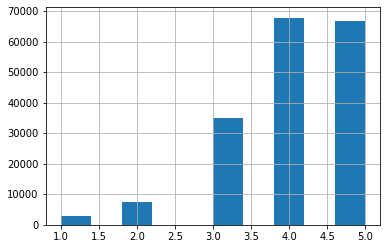

In [96]:
music.rating.hist()

<AxesSubplot:>

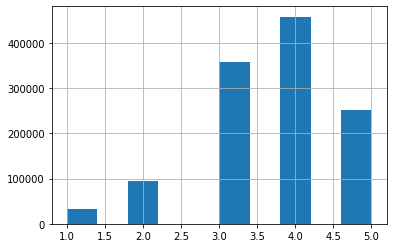

In [97]:
movies.rating.hist()

In [98]:
music_reviewers = set(music.user_id.values)
movie_reviewers = set(movies.user_id.values)
print(f"Movie users: {len(movie_reviewers)}")
print(f"Music users: {len(music_reviewers)}")
in_movies_from_music = movies.loc[movies.user_id.apply(lambda x: x in music_reviewers),:]
in_music_from_movies = music.loc[music.user_id.apply(lambda x: x in movie_reviewers),:]
cross_reviewers = set(in_music_from_movies.user_id.values)
print(f"Cross users: {len(cross_reviewers)}")
print(f"{len(in_movies_from_music.user_id.unique()) / len(movie_reviewers) * 100:.3f}% of movie reviewers")
print(f"{len(in_movies_from_music.user_id.unique()) / len(music_reviewers) * 100:.3f}% of music reviewers")
in_music_from_movies

Movie users: 2712
Music users: 1820
Cross users: 1815
66.925% of movie reviewers
99.725% of music reviewers


,user_id,music_id,rating,labels,comment,useful_num,time
ID,,,,,,,
1,843,52381,5,ACG|Anime|MegaloBox|OST,预订今年最强,5,2018-06-29
2,843,52663,3,,看样子现在的音乐不止华语不行了,0,2018-06-14
3,843,52032,5,,现在仅此片刻请让我收起雨伞沐浴在你的细雨中吧这份无论何时都湛蓝如洗仅凭缅怀便不能去触碰之物现...,0,2018-06-09
4,843,18446,5,,一句就让当时的我毛骨悚然,0,2018-05-16
5,843,5380,5,仙剑奇侠传|OST|仙剑|胡歌|电视原声|内地|华语,想起梦到了李逍遥回忆到了暑假在房顶拿着随身边听边唱的蝉鸣,0,2018-04-12
...,...,...,...,...,...,...,...
179843,2267,25530,5,Instrumental,指弹大师,0,2013-06-30
179844,2267,11455,5,Experimental|Live|Indie,即便对窦唯的音符深深迷恋但也从来没有听到第一个引出来就激动成这样子过,4,2013-06-30
179845,2267,74993,5,Pop,只能自己看着歌词静静想象,2,2013-04-25


In [99]:
movie_items = set(movies.movie_id.values)
music_items = set(music.music_id.values)
print(f"Movie items: {len(movie_items)}")
print(f"Music items: {len(music_items)}")

Movie items: 34893
Music items: 79878


In [100]:
only_movie_reviewers_id = movie_reviewers.difference(cross_reviewers)
only_movie_reviewers_matrix = movies.loc[[True if reviewer in only_movie_reviewers_id else False for reviewer in movies.user_id], :]
only_movie_reviewers_map = {val: i for i, val in enumerate(only_movie_reviewers_id)}
movie_items_map = {val: i for i, val in enumerate(movie_items)}
MoX = scipy.sparse.csr_matrix((only_movie_reviewers_matrix.rating,
                              ([only_movie_reviewers_map[elem] for elem in only_movie_reviewers_matrix.user_id],
                               [movie_items_map[elem] for elem in only_movie_reviewers_matrix.movie_id])),
                              dtype=np.uint8,
                              shape=(len(only_movie_reviewers_id), len(movie_items) + len(music_items)))
MoX

<897x114771 sparse matrix of type '<class 'numpy.uint8'>'
	with 262284 stored elements in Compressed Sparse Row format>

In [103]:
only_music_reviewers_id = music_reviewers.difference(cross_reviewers)
only_music_reviewers_matrix = music.loc[[True if reviewer in only_music_reviewers_id else False for reviewer in music.user_id], :]
only_music_reviewers_map = {val: i for i, val in enumerate(only_music_reviewers_id)}
music_items_map = {val: i for i, val in enumerate(music_items)}
MuX = scipy.sparse.csr_matrix((only_music_reviewers_matrix.rating,
                              ([only_music_reviewers_map[elem] for elem in only_music_reviewers_matrix.user_id],
                               [len(movie_items) + music_items_map[elem] for elem in only_music_reviewers_matrix.music_id])),
                              dtype=np.uint8,
                              shape=(len(only_music_reviewers_id), len(movie_items) + len(music_items)))
MuX

<5x114771 sparse matrix of type '<class 'numpy.uint8'>'
	with 48 stored elements in Compressed Sparse Row format>

In [104]:
cross_reviewers_movie_matrix = movies.loc[[True if reviewer in cross_reviewers else False for reviewer in movies.user_id], :]
cross_reviewers_music_matrix = music.loc[[True if reviewer in cross_reviewers else False for reviewer in music.user_id], :]
cross_reviewers_map = {val: i for i, val in enumerate(cross_reviewers)}
CrMoX = scipy.sparse.csr_matrix((cross_reviewers_movie_matrix.rating,
                                ([cross_reviewers_map[elem] for elem in cross_reviewers_movie_matrix.user_id],
                                 [movie_items_map[elem] for elem in cross_reviewers_movie_matrix.movie_id])),
                                dtype=np.uint8,
                                shape=(len(cross_reviewers), len(movie_items)))
CrMuX = scipy.sparse.csr_matrix((cross_reviewers_music_matrix.rating,
                                ([cross_reviewers_map[elem] for elem in cross_reviewers_music_matrix.user_id],
                                 [music_items_map[elem] for elem in cross_reviewers_music_matrix.music_id])),
                                dtype=np.uint8,
                                shape=(len(cross_reviewers), len(music_items)))
CrX = scipy.sparse.hstack([CrMoX, CrMuX]).tocsr()
CrX

<1815x114771 sparse matrix of type '<class 'numpy.uint8'>'
	with 1115785 stored elements in Compressed Sparse Row format>

In [107]:
X = CrX
print(set(X.data))  # Must be [1; 5]
X

{1, 2, 3, 4, 5}


<1815x114771 sparse matrix of type '<class 'numpy.uint8'>'
	with 1115785 stored elements in Compressed Sparse Row format>

In [108]:
from sklearn.model_selection import ShuffleSplit
random_state = 12345

split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
for train, test in split.split(X):
    print(test)
    X_train_part = X[train]
    X_test_part = scipy.sparse.hstack([CrMoX[test], scipy.sparse.csr_matrix((test.shape[0], CrMuX.shape[1]))]).tocsr()
    X_train = CrMuX[train]  # items from train subsample
    X_test = CrMuX[test]    # test subsample
X_train


[ 621  980 1429  426  374  190 1423  427 1655  567 1710 1359  816  528
 1559 1437  895  787  910 1771 1525 1507 1628   33  674  799  563 1776
  838 1782  101 1349 1362 1370 1471 1303 1664 1401  207  328 1476  109
 1220 1686 1325  521 1172  193  540  608  260  154  187 1278 1070 1046
  901 1575  965 1581  571  894  842 1276  171  151  927 1755 1687  664
 1240  164  432  819  529  180  324  955  294  423  603  201  995  467
  403 1004 1574  111 1019 1098  806  794 1501 1305  706  617  380 1128
  137 1052 1805  523  541 1181  178 1447 1156   72 1602 1712  413 1729
   92 1011  938  227 1196 1500  848  264  811 1051  843   76  394    8
  208  673 1197  149 1563   17  418  837 1134   56  963  940  812 1808
 1639 1556 1355 1668 1800  994  361 1069  655 1517  390 1105 1770 1073
   22  206  798  338 1789 1290  786  968 1412 1360 1624  981 1722  873
  136 1526  462    3 1389  162 1802  667  209 1620  453  456 1111  581
 1343 1313  622  740 1787  302 1752  284 1803  314  770  445 1790  357
  414 

<1452x79878 sparse matrix of type '<class 'numpy.uint8'>'
	with 143033 stored elements in Compressed Sparse Row format>

In [109]:
# [(popularity, item)]
top_pop_items = sorted([(v, i) for i, v in enumerate(X_train.sum(axis=0).tolist()[0])], reverse=True)

In [110]:
at = 10

recommendation = top_pop_items[:at]

idcg = 0
for i in range(at):
    idcg += 1/math.log2(i + 2)

for train, test in split.split(X):
    map = 0
    mean_ndcg = 0
    with tqdm.tqdm(total=X_test.shape[0]) as it:
        for row in X_test:
            relevant_items = row.indices[row.data > 3]

            num_relevant = 0
            dcg = 0
            for i, rec in enumerate(recommendation):
                if rec[1] in relevant_items:
                    num_relevant += 1
                    dcg += 1/math.log2(i + 2)

            map += num_relevant / at
            mean_ndcg += dcg
            it.update(1)
    map /= X_test.shape[0]
    mean_ndcg /= X_test.shape[0] * idcg

    print(f"{X_test.shape[0]} users taken")
    print(f"MAP@{at}: {map}")
    print(f"Mean NDCG@{at}: {mean_ndcg}")


100%|██████████| 363/363 [00:00<00:00, 12680.27it/s]

363 users taken
MAP@10: 0.049862258953168016
Mean NDCG@10: 0.05027873255725948
